# Download

In [ ]:
!pip install opendatasets --upgrade
!pip install isodate

In [ ]:
import opendatasets as od
od.download_kaggle_dataset("https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews", "data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: a
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews


100%|██████████| 723M/723M [00:06<00:00, 121MB/s]


# Libs

In [ ]:
import pandas as pd
import isodate # for total, prep and cook times
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import json
# isodate.parse_duration("PT24H45M") # para el futuro

# Dataset

In [ ]:
recipes = pd.read_parquet("data/foodcom-recipes-and-reviews/recipes.parquet")
reviews = pd.read_parquet("data/foodcom-recipes-and-reviews/reviews.parquet")

In [ ]:
recipes.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')

In [ ]:
reviews.columns

Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review',
       'DateSubmitted', 'DateModified'],
      dtype='object')

In [ ]:
# hay 7368 ingredientes diferentes
all_ingredients = set()
for i in range(len(recipes)):
    all_ingredients.update(recipes["RecipeIngredientParts"].loc[i])
# y 9 elementos nutricionales
ingredients_mapper = {ingredient: i for i, ingredient in enumerate(list(all_ingredients))}
nutrition_facts = [
    'Calories', 'FatContent','SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent'
]
recipes_cols = ["RecipeId", "RecipeIngredientParts"] + nutrition_facts
len(all_ingredients), len(nutrition_facts)

(7368, 9)

## Filter by main components

In [ ]:
recipes = recipes[recipes_cols]
# recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].apply(lambda x: [ing if type(ing) == int else ingredients_mapper[ing] for ing in x])
# recipes['RecipeId'] = recipes['RecipeId'].astype(int)
# recipes.head()

In [ ]:
len(reviews)

1401982

In [ ]:
recipes_records = recipes["RecipeId"].unique()
reviews = reviews[reviews["RecipeId"].isin(recipes_records)]
len(reviews)

1401963

In [ ]:
reviews = reviews.reset_index(drop=True)

In [ ]:
reviews.columns

Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review',
       'DateSubmitted', 'DateModified'],
      dtype='object')

In [ ]:
reviews = reviews[["RecipeId", "AuthorId", "Rating"]]

# Test splitting

In [ ]:
train_indices = []
test_indices = []

grouped = reviews.groupby('AuthorId')
min_ratings = 3

for user_id, group in grouped:
    if len(group) >= min_ratings:
        train_idx, test_idx = train_test_split(
            group.index,
            test_size=0.3,
            random_state=42
        )
        # stratify no se puede usar
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)
    else:
        # Si el usuario tiene menos rating de los que definimos como mínimo, lo dejamos en train (no en test)
        train_indices.extend(group.index)


train = reviews.iloc[train_indices].copy().reset_index(drop=True)
test = reviews.iloc[test_indices].copy().reset_index(drop=True)

# Verificar las proporciones
print(f"Train set size: {len(train)} ({len(train)/len(reviews):.2%})")
print(f"Test set size: {len(test)} ({len(test)/len(reviews):.2%})")

Train set size: 1038919 (74.10%)
Test set size: 363044 (25.90%)


In [ ]:
test_grouped = test.groupby('AuthorId')['AuthorId'].count().sort_values(ascending=False)
test_grouped

,AuthorId
AuthorId,
424680,2653
37449,1982
383346,1632
128473,1408
169430,1376
...,...
433531,1
1197616,1
433516,1


In [ ]:
users_train = train['AuthorId'].unique()
users_test  = test['AuthorId'].unique()
unique_values = set(users_test) - set(users_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

users_train = train['RecipeId'].unique()
users_test  = test['RecipeId'].unique()
unique_values = set(users_test) - set(users_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

All values from list1 are also in list2.
Values in list1 but not in list2: {262145, 131078, 131079, 393224, 131081, 393237, 131106, 131107, 46, 393262, 393264, 131123, 52, 131126, 60, 393282, 262212, 393288, 131144, 393299, 131159, 393303, 89, 262236, 262237, 99, 131172, 131180, 393324, 131182, 393327, 113, 131194, 393340, 262269, 131198, 393343, 141, 393372, 262301, 161, 131233, 131237, 131238, 262313, 171, 178, 131251, 393397, 131254, 189, 393409, 194, 205, 206, 262351, 393421, 209, 131278, 393437, 131294, 393438, 226, 262374, 131311, 262385, 262386, 393464, 262396, 131330, 262404, 393479, 131343, 273, 131348, 279, 393496, 282, 284, 289, 131361, 291, 131364, 393505, 294, 262449, 131387, 393538, 524611, 131394, 131403, 332, 340, 393560, 262494, 262497, 131431, 393577, 393579, 365, 131441, 371, 262516, 373, 131443, 393589, 393590, 377, 393593, 262523, 262526, 385, 262531, 393605, 131461, 393609, 131466, 393611, 401, 393617, 406, 393627, 393628, 413, 418, 422, 131497, 131499, 131500, 26

In [ ]:
test = test[~test['RecipeId'].isin(unique_values)].reset_index(drop=True)
users_train = train['RecipeId'].unique()
users_test  = test['RecipeId'].unique()
unique_values = set(users_test) - set(users_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

All values from list1 are also in list2.


In [ ]:
train_grouped = train.groupby('AuthorId')['AuthorId'].count().sort_values(ascending=False)
test_grouped = test.groupby('AuthorId')['AuthorId'].count().sort_values(ascending=False)
bins = np.arange(0, 10, 1).astype(float)
bins[-1] = np.inf
y_train, x_train = np.histogram(train_grouped, bins=bins)
y_test, x_test = np.histogram(test_grouped, bins=bins)
x_train = x_train[:-1]
x_test = x_test[:-1]

In [ ]:
reviews_list = reviews[["AuthorId", "RecipeId"]].values.tolist()
rating_list = reviews["Rating"].values.tolist()

In [ ]:
from sklearn.model_selection import LeaveOneOut
# kfold = (n_splits=4, random_state=42, shuffle=True)
loo = LeaveOneOut()
loo.get_n_splits(reviews_list, rating_list)

# kfold_indices = []
# for train_index, test_index in kfold.split(reviews_list, rating_list):
#     kfold_indices.append((train_index, test_index))

1401982

In [ ]:
kfold_indices

((array([      2,       3,       5, ..., 1401977, 1401978, 1401980]),
  array([      0,       1,       4, ..., 1401974, 1401979, 1401981])),
 (array([      0,       1,       3, ..., 1401979, 1401980, 1401981]),
  array([      2,       7,      15, ..., 1401976, 1401977, 1401978])),
 (array([      0,       1,       2, ..., 1401978, 1401979, 1401981]),
  array([      5,      10,      11, ..., 1401973, 1401975, 1401980])),
 (array([      0,       1,       2, ..., 1401979, 1401980, 1401981]),
  array([      3,      12,      17, ..., 1401961, 1401966, 1401969])))

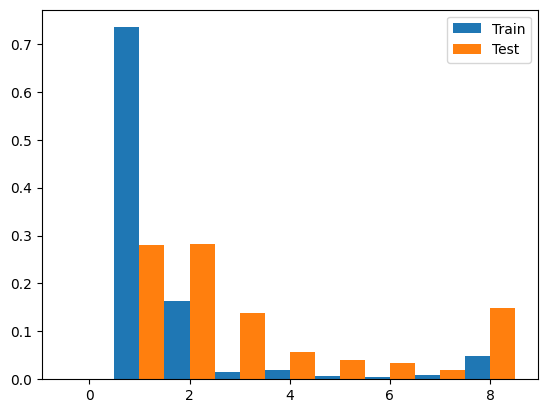

In [ ]:
width = 0.5
offset =  width / 2

plt.bar(
    x_train - offset,
    y_train / sum(y_train),
    width=width,
    label='Train',
)
plt.bar(
    x_test + offset,
    y_test / sum(y_test),
    width=width,
    label='Test',

)
plt.legend()
plt.show()

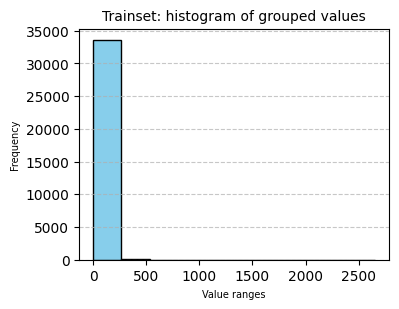

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_grouped = test.groupby('AuthorId')['AuthorId'].count().sort_values(ascending=False)

# Crear un histograma
plt.figure(figsize=(4, 3))
plt.hist(train_grouped, bins=10, color='skyblue', edgecolor='black')

plt.title("Trainset: histogram of grouped values", fontsize=10)
plt.xlabel("Value ranges", fontsize=7)
plt.ylabel("Frequency", fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Rewrite Ids
Los ids no se encuentran en el rango de 0 a len(unique_reviews_ids) por lo que se debe mapear a este rango. Nos quedaremos solo con los ids de las reviews

In [ ]:
min(recipes["RecipeId"]) , min(reviews["RecipeId"]), max(recipes["RecipeId"]) , max(reviews["RecipeId"])

(38.0, 38, 541383.0, 541298)

In [ ]:
recipes["RecipeId"] = recipes["RecipeId"].astype(int)

In [ ]:
all_recipes_ids = train["RecipeId"].unique()
all_recipes_ids.sort()

all_user_ids = train["AuthorId"].unique()
all_user_ids.sort()

In [ ]:
len(all_recipes_ids)

238658

In [ ]:
recipes = recipes[recipes["RecipeId"].isin(all_recipes_ids)]

In [ ]:
len(recipes)

238658

In [ ]:
recipe_id_mapper = {int(recipe_id): i for i, recipe_id in enumerate(all_recipes_ids)}
user_id_mapper = {int(user_id): i for i, user_id in enumerate(all_user_ids)}
with open("mappers.json", "w") as f:
    json.dump({"recipe_id_mapper": recipe_id_mapper, "user_id_mapper": user_id_mapper}, f)

In [ ]:
train["RecipeId"] = train["RecipeId"].apply(lambda x: recipe_id_mapper[x])
test["RecipeId"] = test["RecipeId"].apply(lambda x: recipe_id_mapper[x])
train["AuthorId"] = train["AuthorId"].apply(lambda x: user_id_mapper[x])
test["AuthorId"] = test["AuthorId"].apply(lambda x: user_id_mapper[x])
recipes["RecipeId"] = recipes["RecipeId"].apply(lambda x: recipe_id_mapper[x])


In [ ]:
len(reviews)

1401982

In [ ]:
min(train["RecipeId"]), max(train["RecipeId"]), len(train["RecipeId"].unique())

(0, 238678, 238679)

In [ ]:
max(recipes["RecipeId"]), len(recipes["RecipeId"].unique())

238678

In [ ]:
all_ingredients = set()
for i in range(len(recipes)):
    all_ingredients.update(recipes["RecipeIngredientParts"].iloc[i])
new_ingredients_mapper = {ingredient: i for i, ingredient in enumerate(list(all_ingredients))}

In [ ]:
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].apply(lambda x: [new_ingredients_mapper[ing] for ing in x])

# Save split

In [ ]:
train.to_csv("review_train.csv", index=False)
test.to_csv("review_test.csv", index=False)
recipes.to_csv("recipes.csv", index=False)

In [ ]:
a = pd.read_csv("review_train.csv")
min(a["RecipeId"]), max(a["RecipeId"]), len(a["RecipeId"].unique())

(0, 238657, 238658)

In [ ]:
recipes.to_csv("recipes.csv", index=False)

In [ ]:
_all_ingredients = set()
for i in range(len(recipes)):
    _all_ingredients.update(recipes["RecipeIngredientParts"].iloc[i])

In [ ]:
all_ingredients - _all_ingredients

{6156,
 6157,
 6158,
 6159,
 6160,
 6161,
 6162,
 6163,
 6165,
 6166,
 6167,
 6168,
 6170,
 6171,
 6172,
 6173,
 6174,
 6175,
 6176,
 6177,
 6178,
 6179,
 6180,
 6181,
 6182,
 6183,
 6184,
 6185,
 6186,
 6187,
 6189,
 6190,
 6191,
 6192,
 6193,
 6194,
 6195,
 6197,
 6198,
 6199,
 6200,
 6201,
 6202,
 6203,
 6204,
 6205,
 6206,
 6207,
 6208,
 6209,
 6211,
 6212,
 6214,
 6215,
 6216,
 6217,
 6218,
 6219,
 6220,
 6221,
 6222,
 6223,
 6224,
 6225,
 6226,
 6227,
 6228,
 6229,
 6230,
 6231,
 6232,
 6233,
 6234,
 6236,
 6238,
 6240,
 6241,
 6242,
 6243,
 6244,
 6245,
 6246,
 6247,
 6248,
 6250,
 6252,
 6253,
 6254,
 6255,
 6256,
 6257,
 6259,
 6260,
 6261,
 6262,
 6263,
 6265,
 6266,
 6268,
 6269,
 6273,
 6274,
 6275,
 6276,
 6277,
 6278,
 6279,
 6280,
 6282,
 6284,
 6285,
 6287,
 6292,
 6293,
 6294,
 6295,
 6296,
 6297,
 6298,
 6299,
 6300,
 6301,
 6302,
 6304,
 6305,
 6307,
 6308,
 6309,
 6310,
 6312,
 6313,
 6314,
 6315,
 6316,
 6319,
 6320,
 6321,
 6322,
 6323,
 6324,
 6325,
 6326,
 6328,

In [ ]:
min(all_ingredients), max(all_ingredients), len(all_ingredients)

(0, 7367, 6156)

In [ ]:
min(_all_ingredients), max(_all_ingredients), len(_all_ingredients)

(0, 6155, 6156)